# Pneumonia Classification
Project by Maria Kaltenbrunner and Mohamed Goha
<br>for Computer Vision (FH Technikum) Fall 2020

## What is our project?
We want to train a model which is able to classify y-ray images of lungs into pneumonic and non-pneumonic. 

## What is Pneumonia?

Pneumonia is inflammation of tissue in the lungs. It's commonly caused by a bacterial infection, but can also be caused by a virus. Pneumonia is hard to diagnose because it shares many symptoms with other conditions such as the common cold, bronchitis and asthma. The diagnosis of Pneumonia is most often confirmed by a chest X-Ray.
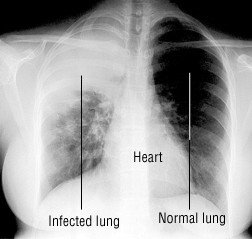


## Import the necessary packages

In [3]:
import os
import matplotlib as plt
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from keras.backend import clear_session
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Accuracy, Precision, Recall
from keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import datetime
import imgaug.augmenters as augm
import optuna
from imblearn.over_sampling import SMOTE
import pandas as pd
from pathlib import Path
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from keras.utils import to_categorical

In [2]:
tf.disable_v2_behavior()
tf.enable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


## Description of the Pneumonia Dataset
The [Pneumonia Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) from Kaggle is organized in three folders (Test, Train and Val) and with subfolders for the two categories (Pneumonia and Normal). There are 5,856 X-Ray images in JPEG-format. Pneumonia caused by viruses or bacteria are grouped together.

![0_basic_data_structure.png](documentation/images/0_basic_data_structure.png)

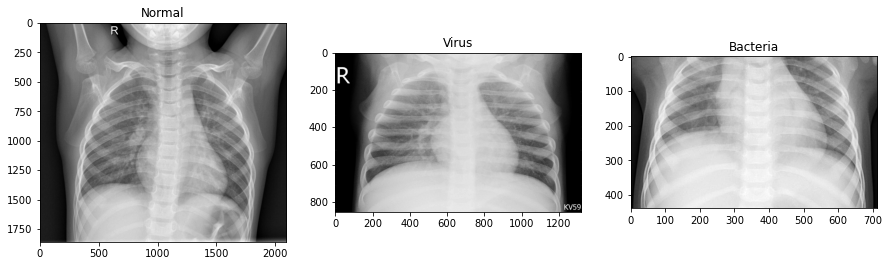

In [4]:
bacteria = cv2.imread('data/train/PNEUMONIA/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
virus = cv2.imread('data/train/PNEUMONIA/person1385_virus_2380.jpeg', cv2.IMREAD_GRAYSCALE)
normal = cv2.imread('data/train/NORMAL/IM-0115-0001.jpeg', cv2.IMREAD_GRAYSCALE)

f, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(normal, cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(virus, cmap='gray')
ax[1].set_title('Virus')
ax[2].imshow(bacteria, cmap='gray')
ax[2].set_title('Bacteria')
plt.show()

<b>For untrained persons, the difference between healthy lungs and those affected by Pneumonia are not easily distinguishable. However, there are certain effects which show visual signs in X-rays.</b>

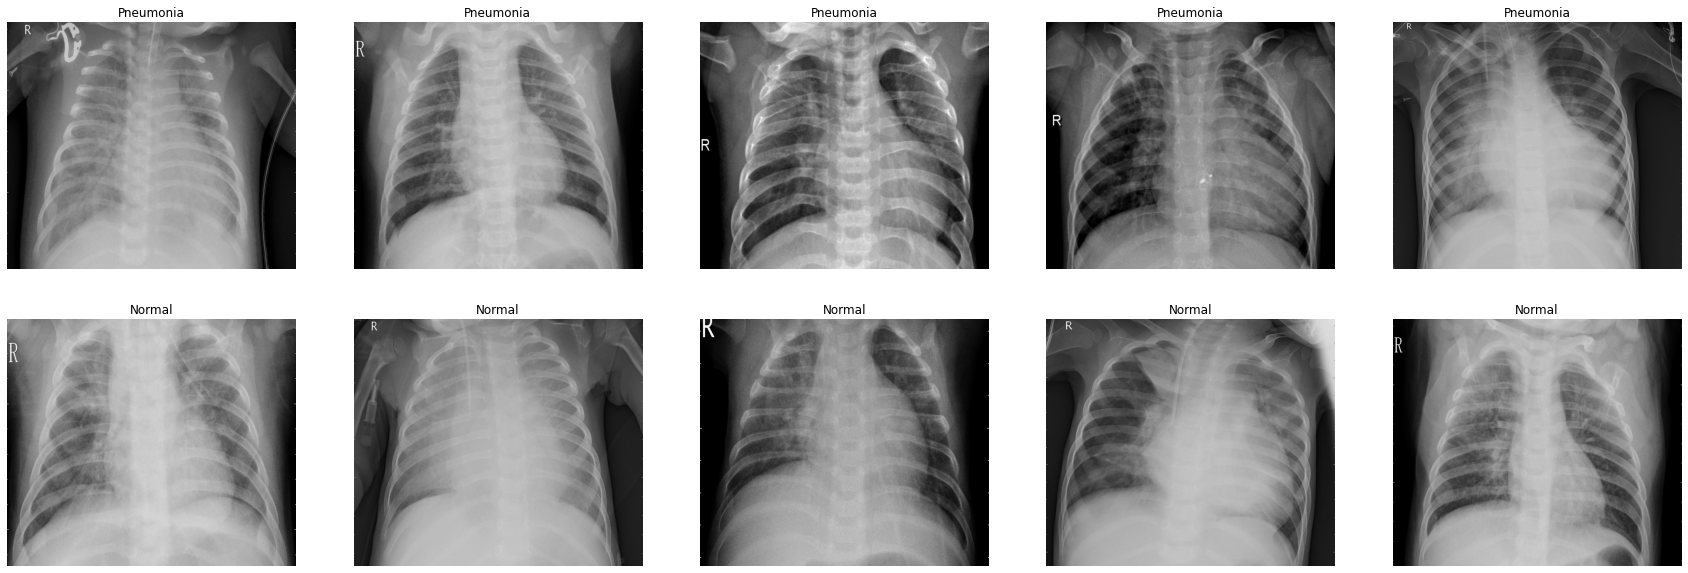

In [5]:
# Get few samples for both the classes
normal = os.listdir('data/train/NORMAL')
pneumonia = os.listdir('data/train/PNEUMONIA')

normal_samples = []
pneumonia_samples = []

for i in range(10):
    normal_samples.append(cv2.imread(os.path.join('data/train/NORMAL', normal[i]),cv2.IMREAD_GRAYSCALE))
    pneumonia_samples.append(cv2.imread(os.path.join('data/train/PNEUMONIA', pneumonia[i]), cv2.IMREAD_GRAYSCALE))

samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = samples[i]
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

## Loading the Dataset

In [6]:
def load_images(data_dir, folder, img_size, color = False):
    """
    Loads images from a folder, resizes them and stores them in a numpy array.
   
    Parameters:
    data_dir -- string, the path to to the main data folder
    img_size: integer, to this value the loaded images are resized before returned
    
    Returns:
    data -- list of numpy arrays, containing data and labels of train, test and validation
    """
    data_dir = os.path.join(data_dir, folder)
    label_folders = os.listdir(data_dir)
    colors = {True: cv2.IMREAD_COLOR, False: cv2.IMREAD_GRAYSCALE}

    images_original = []
    string_labels = []
    for folder in label_folders:
        folder_path = os.path.join(data_dir, folder)
        filenames = os.listdir(folder_path)
        filepaths = [os.path.join(folder_path, name) for name in filenames]
        images_original += [cv2.imread(file, colors[color]) for file in filepaths]
        images_resized = [cv2.resize(img, (img_size, img_size)) for img in images_original]
        string_labels += [folder for _ in filenames]
    
    final_images = []
    for img in images_resized:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            final_images.append(img)
            
    return (np.array(final_images), np.array(string_labels))

In [7]:
data_dir = 'data'
folders = os.listdir(data_dir)
img_size = 50

print("Folders:", folders)

test_X, test_y =  load_images(data_dir, folders[0], img_size)
train_X, train_y = load_images(data_dir, folders[1], img_size)
val_X, val_y = load_images(data_dir, folders[2], img_size)

Folders: ['test', 'train', 'val']


## Data exploration and preprocessing

In [8]:
print('shapes:')
print('training data: ', train_X.shape)
print('training labels: ', train_y.shape)

print('test data: ', test_X.shape)
print('test labels: ', test_y.shape)

print('val data: ', val_X.shape)
print('val labels: ', val_y.shape)

print('training label strings: ',np.unique(train_y))
print('testing labels strings: ', np.unique(test_y))
print('validation labels strings: ', np.unique(val_y))

shapes:
training data:  (5216, 50, 50, 3)
training labels:  (5216,)
test data:  (624, 50, 50, 3)
test labels:  (624,)
val data:  (16, 50, 50, 3)
val labels:  (16,)
training label strings:  ['NORMAL' 'PNEUMONIA']
testing labels strings:  ['NORMAL' 'PNEUMONIA']
validation labels strings:  ['NORMAL' 'PNEUMONIA']


<b>The dataset includes 5,856 images, however the data is unbalanced.</b>

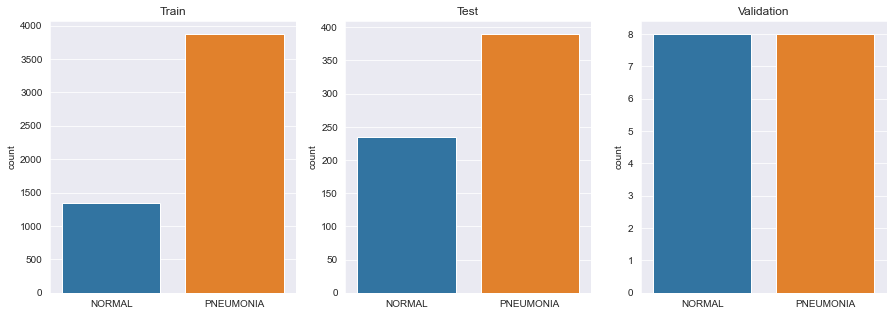

In [9]:
sns.set_style('darkgrid')
f, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].set_title('Train')
sns.countplot(ax=ax[0], x= train_y)  
ax[1].set_title('Test')
sns.countplot(ax=ax[1], x= test_y)  
ax[2].set_title('Validation')
sns.countplot(ax=ax[2], x= val_y)  
plt.show()

<b>The images were resized to make it possible to train the CNN on our limited ressources.</b>

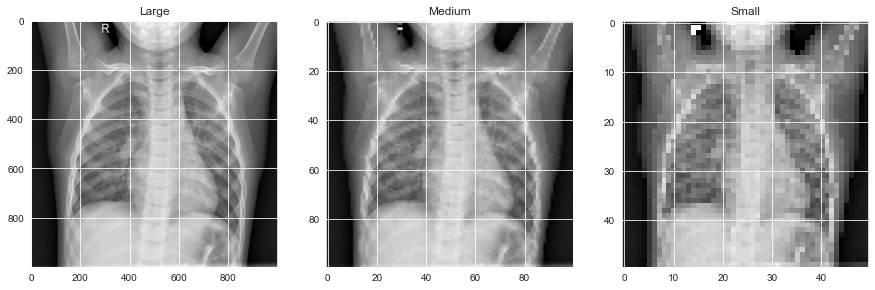

In [10]:
example = cv2.imread('data/train/NORMAL/IM-0115-0001.jpeg', cv2.IMREAD_GRAYSCALE)
large = cv2.resize(example, (1000,1000))
medium = cv2.resize(example, (100, 100))
small = cv2.resize(example, (50, 50))

f, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(large, cmap='gray')
ax[0].set_title('Large')
ax[1].imshow(medium, cmap='gray')
ax[1].set_title('Medium')
ax[2].imshow(small, cmap='gray')
ax[2].set_title('Small')
plt.show()

## Data Augmentation

In [11]:
# Sequence from which on augmentation process is chosen
seq = augm.OneOf([
    augm.Fliplr(),
    augm.Affine(rotate=20),
    augm.Multiply((0.8, 1.2))
])

In [12]:
# Load the normal images
images_original = []
labels_augmented = []
images_augmented = []

folder_path = 'data/train/NORMAL'
filenames = os.listdir(folder_path)
filepaths = [os.path.join(folder_path, name) for name in filenames]

images_original += [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in filepaths]
images_resized = [cv2.resize(img, (img_size, img_size)) for img in images_original]

for img in images_resized:
    aug_img = seq.augment_image(img)
    images_augmented.append(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
    labels_augmented.append('NORMAL')

old_train_y = train_y #for visualizing purposes later

In [13]:
train_X = np.concatenate((train_X, np.array(images_augmented)), axis=0)
train_y = np.concatenate((train_y, np.array(labels_augmented)), axis=0)

In [14]:
print(np.array(images_original).shape)
print(train_X.shape)
print(train_y.shape)

(1341,)
(6557, 50, 50, 3)
(6557,)


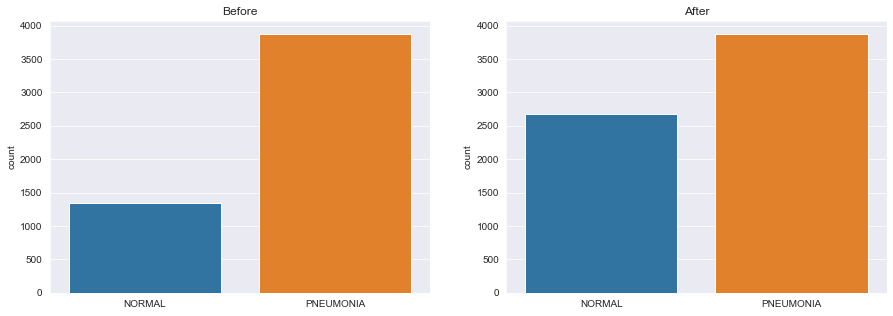

In [15]:
sns.set_style('darkgrid')
f, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title('Before')
sns.countplot(ax=ax[0], x= old_train_y)  
ax[1].set_title('After')
sns.countplot(ax=ax[1], x= train_y)  
plt.show()

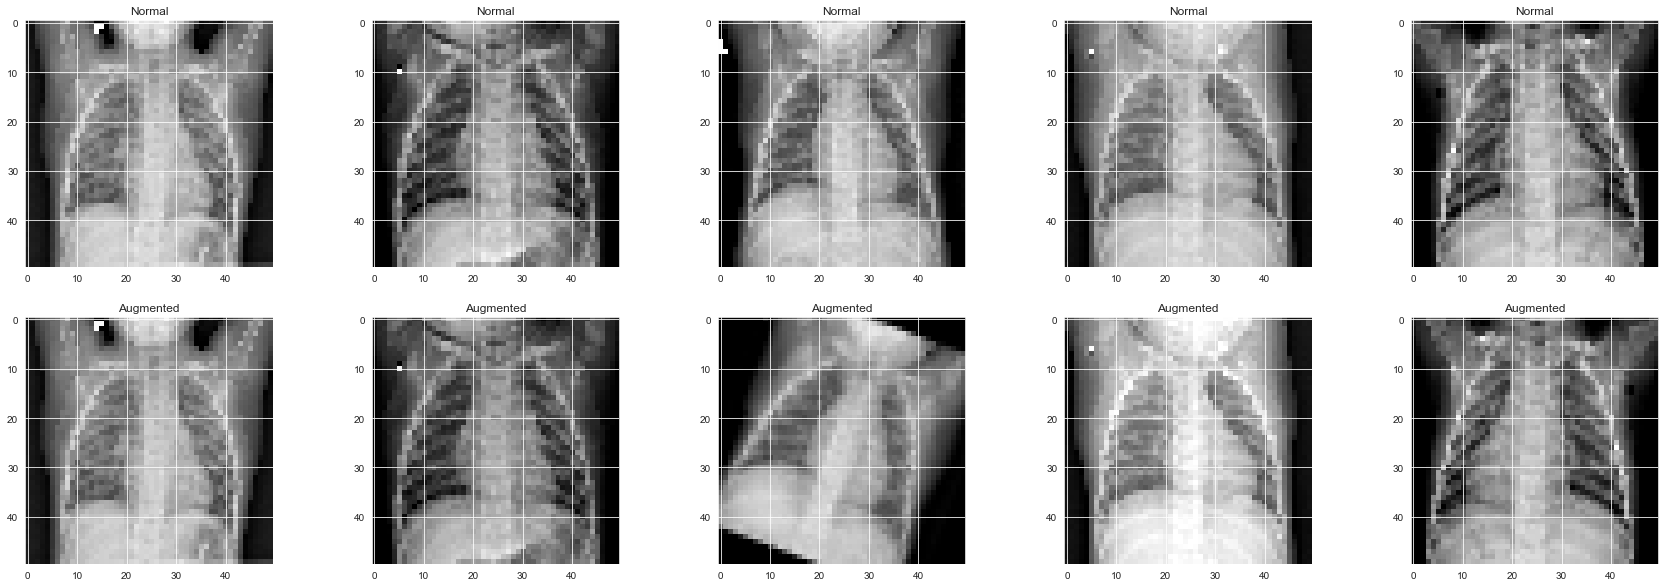

In [18]:
f, ax = plt.subplots(2, 5, figsize=(30,10))

image_sample = images_resized[:5]+images_augmented[:5]        

for i in range(10):
    img = image_sample[i]
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Augmented")
plt.show()

<b>The data is normalized.</b>

In [19]:
train_X = np.array(train_X) / 255.
val_X = np.array(val_X) / 255.
test_X = np.array(test_X) / 255.

## One-Hot Encoding

In [20]:
test_Y = []
counter = 0
counter1 = 0
for label in test_y:
    if label == 'NORMAL':
        counter += 1
        #test_Y = np.append(test_Y, 0)
        test_Y.append(to_categorical(0, num_classes=2))
    elif label == 'PNEUMONIA':
        counter1 += 1
        #test_Y = np.append(test_Y, 1)
        test_Y.append(to_categorical(1, num_classes=2))
test_Y = np.array(test_Y)
test_y = test_Y
print(test_Y[:10])
print('number of normal cases in test data: ',counter )
print('number of pneumonia cases in test data: ',counter1 )

train_Y = []
counter = 0
counter1 = 0
for label in train_y:
    if label == 'NORMAL':
        counter += 1
        train_Y.append(to_categorical(0, num_classes=2))
    elif label == 'PNEUMONIA':
        counter1 += 1
        train_Y.append(to_categorical(1, num_classes=2))
train_Y = np.array(train_Y)
print('shape: ',train_Y.shape)
train_y = train_Y
print(train_Y[:10])
print('number of normal cases in train data: ',counter )
print('number of pneumonia cases in train data: ',counter1 )

val_Y = []
counter = 0
counter1 = 0
for label in val_y:
    if label == 'NORMAL':
        counter += 1
        val_Y.append(to_categorical(0, num_classes=2))
    elif label == 'PNEUMONIA':
        counter1 += 1
        val_Y.append(to_categorical(1, num_classes=2))
val_Y = np.array(val_Y)
print('shape: ',val_Y.shape)
val_y = val_Y
print(val_Y[:10])
print('number of normal cases in val data: ',counter )
print('number of pneumonia cases in val data: ',counter1 )

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
number of normal cases in test data:  234
number of pneumonia cases in test data:  390
shape:  (6557, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
number of normal cases in train data:  2682
number of pneumonia cases in train data:  3875
shape:  (16, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
number of normal cases in val data:  8
number of pneumonia cases in val data:  8


## Hyperparameter optimization

In [ ]:
BATCHSIZE = 1000
EPOCHS = 5

def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()

    input_shape = (train_X.shape[1],train_X.shape[2],train_X.shape[3])
    
    model = Sequential()
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters", [6, 20]),
            kernel_size=trial.suggest_categorical("kernel_size", [3, 5]),
            strides=trial.suggest_categorical("strides", [1, 2]),
            activation=trial.suggest_categorical("activation", ["relu"]),
            input_shape=input_shape,
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(
        Conv2D(
            filters=trial.suggest_categorical("filters2", [16, 30]),
            kernel_size=trial.suggest_categorical("kernel_size2", [3, 5]),
            strides=trial.suggest_categorical("strides2", [1, 2]),
            activation=trial.suggest_categorical("activation2", ["relu"]),
            #input_shape=input_shape,
        )
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(trial.suggest_categorical("nodeslayer1", [512,1024]), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(trial.suggest_categorical("nodeslayer2", [128,200]), activation="relu"))
    model.add(Dense(2, activation="sigmoid"))

    # We compile our model with a sampled learning rate.
    #lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
    )

    model.fit(
        train_X,
        train_y,
        validation_data=(val_X, val_y),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(val_X, val_y, verbose=0)
    return score[1]

In [23]:
tf.disable_eager_execution()

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## Building the model with optimized hyperparameters

In [24]:
clear_session()
model = Sequential()
model.add(Conv2D(6, (3, 3), strides=(1,1), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(30, (5, 5), strides=(1,1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 6)         168       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 30)        4530      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)             

In [ ]:
clear_session()
model2 = Sequential()
model2.add(Conv2D(6, (3, 3), strides=(1,1), activation='relu', input_shape=(img_size, img_size, 3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(30, (5, 5), strides=(1,1), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(200, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))
model2.summary()

In [25]:
BATCHSIZE = 32
EPOCHS = 10

my_loss = tf.keras.losses.BinaryCrossentropy()
accuracy = tf.keras.metrics.Accuracy()
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
adam = Adam(lr = 0.0001)
es = EarlyStopping(patience=5)

model.compile(
        loss=my_loss, optimizer=adam, metrics=[accuracy, recall, precision]
    )

history = model.fit(
        train_X,
        train_y,
        validation_data=(val_X, val_y),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        callbacks = [es],
        verbose=1,
        )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6557 samples, validate on 16 samples
Epoch 1/10
6557/6557 [==============================] - 10s 1ms/step - loss: 0.3872 - accuracy: 0.0000e+00 - recall: 0.7033 - precision: 0.7113 - val_loss: 0.6076 - val_accuracy: 0.0000e+00 - val_recall: 0.8193 - val_precision: 0.8191
Epoch 2/10
6557/6557 [==============================] - 10s 2ms/step - loss: 0.1649 - accuracy: 0.0000e+00 - recall: 0.8549 - precision: 0.8544 - val_loss: 0.8403 - val_accuracy: 0.0000e+00 - val_recall: 0.8791 - val_precision: 0.8786
Epoch 3/10
6557/6557 [==============================] - 9s 1ms/step - loss: 0.1264 - accuracy: 0.0000e+00 - recall: 0.8933 - precision: 0.8928 - val_loss: 0.6122 - val_accuracy: 0.0000e+00 - val_recall: 0.9038 - val_precision: 0.9033
Epoch 4/10
6557/6557 [==============================] - 9s 1ms/step - loss: 0.1109 - accuracy: 0.0000e+00 - recall: 0.9114 - precision: 0.9110 - val_loss: 

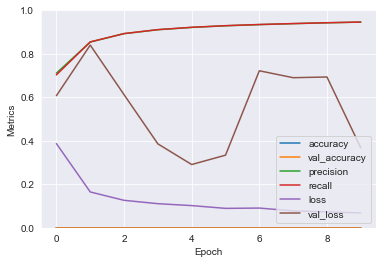

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['precision'], label= 'precision')
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [27]:
test_loss, test_acc, test_recall, test_precision = model.evaluate(test_X,  test_y, verbose=2)

print("Model applied to the test data:")
print("Loss:", test_loss)
print("Accuracy:", test_acc)
print("Recall:", test_recall)
print("Precision:", test_precision)

Model applied to the test data:
Loss: 0.8839745398085469
Accuracy: 0.0
Recall: 0.9462571144104004
Precision: 0.945965588092804


## Archive: Homemade Model
Before working with the Keras Model, we built our own CNN to work on the data. After realizing that we needed a more complex architecture to deal with the data we switched to Keras.

In [ ]:
CONV1_f = 3
CONV1_n = 6
CONV2_f = 3
CONV2_n = 16
FULL1_n = 512
FULL2_n = 128

class CNN:
    def __init__(self, num_classes, image_height, image_width, image_channels, batch_size, learning_rate):

        self.input = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width, image_channels), name='input')
        
        if(num_classes > 2):
            self.output = tf.placeholder(tf.float32, shape=[batch_size, num_classes], name='output')
        else:
            self.output = tf.placeholder(tf.float32, shape=[batch_size, 1], name='output')
            
        self.num = tf.placeholder(tf.int32)
        
        #first convolutional layer
        kernel1 = tf.Variable(tf.random_normal([CONV1_f, CONV1_f, image_channels, CONV1_n]))
        self.cl1_k = tf.nn.conv2d(self.input, kernel1, strides= 1, padding='VALID')
        self.cl1_b = tf.Variable(tf.random_normal([1, CONV1_n]))
        self.cl1_z = tf.add(self.cl1_k, self.cl1_b)
        self.cl1_a = tf.nn.relu(self.cl1_z)
        self.cl1_output = tf.nn.max_pool(self.cl1_a, ksize=[ 1, 2, 2, 1 ], strides=[ 1, 2, 2, 1 ], padding = 'VALID')
        
        #second convolutional layer
        kernel2 = tf.Variable(tf.random_normal([CONV2_f, CONV2_f, self.cl1_output.shape[3], CONV2_n]))
        self.cl2_k = tf.nn.conv2d(self.cl1_output, kernel2, strides= 1, padding='VALID')
        self.cl2_b = tf.Variable(tf.random_normal([1, CONV2_n]))
        self.cl2_z = tf.add(self.cl2_k, self.cl2_b)
        self.cl2_a = tf.nn.relu(self.cl2_z)
        self.cl2_output = tf.nn.max_pool(self.cl2_a, ksize=[ 1, 2, 2, 1 ], strides=[ 1, 2, 2, 1 ], padding = 'VALID')
        
        self.cl2_output = tf.reshape(self.cl2_output, [batch_size, -1])
        
        # two fully connected layers
        if num_classes > 2:
            self.layersizes = [self.cl2_output.shape[1],FULL1_n,FULL2_n,num_classes]
        else:
            self.layersizes = [self.cl2_output.shape[1],FULL1_n,FULL2_n,1]
        self.W = []
        self.B = []
        self.Z = []
        self.A = []
        self.W.append(None)
        self.B.append(None)
        self.Z.append(None)
        self.A.append(self.cl2_output)
        
        for x in range(1,len(self.layersizes)):
            self.W.append(tf.Variable(tf.random_normal([self.layersizes[x-1], self.layersizes[x]])))
            self.B.append(tf.Variable(tf.random_normal([1, self.layersizes[x]])))
            self.Z.append(tf.add(tf.matmul(self.A[x-1], self.W[x]), self.B[x]))
            self.A.append(tf.nn.relu(self.Z[x]))
            
        # set up the final layer
        if num_classes > 2:
            
            self.prediction = tf.nn.softmax(self.Z[-1])
            self.loss = tf.reduce_sum(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.output, logits=self.Z[-1], name='cost')/tf.cast(self.num, tf.float32))
            self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            equal = tf.equal(
                            tf.argmax(self.prediction[0:self.num], 1),
                            tf.argmax(self.output[0:self.num], 1),)
            self.num_correct = tf.reduce_sum(tf.cast(equal, tf.float32), name='accuracy_computation')
            
        else:
            
            self.prediction = tf.nn.sigmoid(self.Z[-1])
            self.loss = tf.reduce_sum(
            tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.output, logits=self.Z[-1], name='cost')/tf.cast(self.num, tf.float32)))
            self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            equal = tf.equal(
                             tf.cast(self.output[0:self.num], tf.bool),
                             tf.cast(tf.round(self.prediction[0:self.num]), tf.bool),)
            self.num_correct = tf.reduce_sum(tf.cast(equal, tf.float32), name='accuracy_computation')

        self.init = tf.global_variables_initializer()

In [ ]:
tf.disable_eager_execution()
tf.reset_default_graph()
image_height = train_X.shape[1]
image_width = train_X.shape[2]
image_channels = 1
batch_size = train_X.shape[0] # use all images at once, no real batching
epochs = 100
learning_rate = 0.02
model = CNN(2, image_height, image_width, image_channels, batch_size, learning_rate)

with tf.Session() as sess:
    sess.run(model.init)
    nowstr = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
    train_writer = tf.summary.FileWriter('cat_cnn_summaries/%s_train' % nowstr, sess.graph)
    test_writer = tf.summary.FileWriter('cat_cnn_summaries/%s_test' % nowstr)

    train_fd = {
        model.num: batch_size,
        model.input: train_X,
        model.output: train_y,
    }
    # the test data does not fill a complete batch, fill the rest up with zeros
    missing = batch_size - test_X.shape[0]
    padded_test_x = np.pad(test_X, [ (0, missing), (0, 0), (0, 0), (0,0) ], 'constant')
    padded_test_y = np.pad(test_y, [ (0, missing),(0,0) ], 'constant')
    print(padded_test_x.shape)
    print(padded_test_y.shape)
    test_fd = {
        model.num: test_X.shape[0],
        model.input: padded_test_x,
        model.output: padded_test_y,
        #model.input: test_X,
        #model.output: test_y,
    }
    
    for epoch in range(1, epochs+1):

        _ = sess.run(model.train_step, feed_dict=train_fd)

        if epoch % 5 == 0:
            train_loss, train_correct = sess.run(
                [ model.loss, model.num_correct ],
                feed_dict=train_fd
            )
            train_acc = train_correct / batch_size
            summary = tf.Summary()
            summary.value.add(tag='loss', simple_value=train_loss)
            train_writer.add_summary(summary, epoch)
            summary = tf.Summary()
            summary.value.add(tag='accuracy', simple_value=train_acc)
            train_writer.add_summary(summary, epoch)
            train_writer.flush()

            test_loss, test_correct = sess.run(
                [ model.loss, model.num_correct ],
                feed_dict=test_fd
            )
            test_acc = test_correct / test_X.shape[0]
            summary = tf.Summary()
            summary.value.add(tag='loss', simple_value=test_loss)
            test_writer.add_summary(summary, epoch)
            summary = tf.Summary()
            summary.value.add(tag='accuracy', simple_value=test_acc)
            test_writer.add_summary(summary, epoch)
            test_writer.flush()
            
            print('Epoch %4d of %d Train loss: %f Train accuracy: %f Test accuracy: %f' %
                  (epoch, epochs, train_loss, train_acc, test_acc))

## Sources
* [Kaggle: Chest X-Tay Pneumonia (Data)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* [Kaggle: Pneumonia Detection using CNN](https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy)
* [Kaggle: beating everything with depthwise convolution](https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution)
* [Pneumonia](https://www.drugs.com/health-guide/pneumonia.html)